In [5]:
import json
import logging
import os
import sys
import urllib
import warnings
from datetime import datetime, date

import pandas as pd
from sqlalchemy import create_engine, text
import json 


### Prepare the data for Band Analysis (RedZoneV2-based vs. Anson's IBV Score-based)

#### Imoport the data with decoded model output JSON

In [ ]:
# import the data and try to parse the JSON output
server = '192.168.1.15'
username = 'Junchen'
password = '9DFXjhhlR3k5'
database = 'BankuityPostOnboarding'

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    f"SERVER={server},1433;DATABASE={database};UID={username};PWD={password};"
    "Encrypt=yes;TrustServerCertificate=yes;"
)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

cnxn = engine.connect()

query1 = f""" 
SELECT *,
          CONVERT(VARCHAR(MAX),
                  DECOMPRESS(ResponseJSON)
         ) AS ResponseJSONText
FROM BankuityPostOnboarding.dbo.SpeedyAnalysis
WHERE ExperimentName = 'loonie_rerun_V2';
"""

df_rerun = pd.read_sql(query1, cnxn)

In [ ]:
print(df_rerun.shape)

(6897, 11)


#### Write the ResponseJSONText to Local (CAREFULL TO RUN!!!!!!!)


In [ ]:
""" output_dir = "/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/rerun_output_JSONs_V2"
os.makedirs(output_dir, exist_ok=True)

for token, response_text in zip(df_rerun.IBVToken.values, df_rerun.ResponseJSONText.values):
    try:
        data = json.loads(response_text) if isinstance(response_text, str) else response_text
        filename = os.path.join(output_dir, f"ModelResponse_{token}.json")
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, separators=(',', ': '), ensure_ascii=False)
    except Exception as e:
        print(token, e) """

#### Extract the RedZoneV2 RiskScore from the JSONs

In [7]:
import re

input_dir = "/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/rerun_output_JSONs_V2"
rows = []

for filename in os.listdir(input_dir):
    if not filename.endswith(".json"):
        continue
    match = re.search(r"_(\d+)\.json$", filename)
    if not match:
        continue
    ibv_status_id = int(match.group(1))
    file_path = os.path.join(input_dir, filename)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            payload = json.load(f)
        customer = (payload or {}).get("customerInfo") or {}
        scores = customer.get("scores", {})
        redzone = scores.get("redZoneV2", {})
        model_score = redzone.get("modelScore")
        risk_score = None
        if isinstance(model_score, list) and model_score:
            first = model_score[0] if isinstance(model_score[0], dict) else None
            risk_score = first.get("riskScore") if first else None
        elif isinstance(model_score, dict):
            risk_score = model_score.get("riskScore")
        rows.append({"IBVStatusID": ibv_status_id, "redZoneV2_score": risk_score})
    except Exception as e:
        rows.append({"IBVStatusID": ibv_status_id, "redZoneV2_score": None})


df_redzone_scores = pd.DataFrame(rows).sort_values("IBVStatusID").reset_index(drop=True)

print(df_redzone_scores.head(10))
print(df_redzone_scores.shape)


   IBVStatusID  redZoneV2_score
0          757       145.000000
1         1258       162.000000
2         1382        78.979465
3         1810       298.000000
4         2334        94.987807
5         3158       224.000000
6         3509       216.000000
7         3513        61.982032
8         3586       154.000000
9         3854       146.000000
(6897, 2)


### attach the application date to redzone table (from previous rerun preparation steps)

In [8]:
# import IBVStatus table + DateProcessed for later deduping
import pandas as pd

dedup_path = "/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/ibv_status_data/loonie_ibv_shadowV5_dedup.csv"
df_dedup = pd.read_csv(dedup_path, usecols=["IBVStatusID", "DateCreated"])

df_redzone_scores = df_redzone_scores.merge(df_dedup, on="IBVStatusID", how="left")

In [9]:
df_redzone_scores

,IBVStatusID,redZoneV2_score,DateCreated
0,757,145.000000,2025-12-04 07:43:09.047
1,1258,162.000000,2025-12-04 14:02:28.853
2,1382,78.979465,2025-12-04 11:43:58.047
3,1810,298.000000,2025-12-04 07:53:09.990
4,2334,94.987807,2025-12-04 10:18:45.287
...,...,...,...
6892,81218,357.599144,2025-12-09 19:32:46.027
6893,81219,301.000000,2025-12-09 19:35:53.077
6894,81220,283.000000,2025-12-09 19:37:01.700
6895,81221,120.000000,2025-12-09 20:00:08.943


### Get the metrics dataframe

In [10]:
from sqlalchemy import create_engine 
import urllib
server = '192.168.1.15'
username = 'Junchen'
password = '9DFXjhhlR3k5'
database = 'LF_LMSMaster'

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    f"SERVER={server},1433;DATABASE={database};UID={username};PWD={password};"
    "Encrypt=yes;TrustServerCertificate=yes;"
)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)


cnxn = engine.connect()
query1 = """ 
USE LF_LMSMASTER

drop table if EXISTS #t1
select ibvT.IBVStatusID, A.Application_ID, A.PortfolioID, A.CustomerID, A.ApplicationDate, CustEmail,
case when ApplicationSteps like '%S%' then 1 else 0 end as NewlyScored,
case when A.ApplicationStatus in ('A','P') then 1 else 0 end as Accepted,
case when A.ApplicationStatus in ('A','P') then A.LeadPurchasePrice else 0 end as LeadPurchasePrice,
case when L.LoanStatus not in ('V','W','G','K') and A.ApplicationStatus='J'  then 1 else 0 end as PartialPreApproved,
case when L.LoanStatus not in ('V','W','G','K')  then 1 else 0 end as Originated,
L.LoanID, datediff(year, VW.DOB, A.ApplicationDate) as Age,
case when VW.Frequency in ('B','S') then 'B' else VW.Frequency end as Frequency,
case when L.LoanStatus not in ('V','W','G','K') then L.OriginatedAmount else null end as OriginatedAmount,
LP.Provider_name, OriginationDate, LOANSTATUS,
case when ((L.RenewalLoanId <> '0') or (A.LPCampaign = 'RENEW'))  then 'RENEWAL' when ApplicationSteps not like '%R%' then 'NEW' else 'REPEAT' end as CustType, RenewalLoanId
into #t1
from Application A
left join Loans L on A.Application_ID = L.ApplicationID and A.PortFolioID = L.PortFolioID
left join LeadProvider LP on A.LeadProviderID = LP.LeadProviderID
left join LF_LMS_Logs..VW_ApplicationDump VW on A.APPGUID = VW.APPGUID
left join [LF_BankData].[dbo].[IBVStatus] as ibvT on ibvT.AccountNumber = A.CustomerSSN
--LEFT join [LF_BankData].[dbo].[IBVStatus] as ibvT on ibvT.ApplicationID = A.Application_ID AND ibvT.PortfolioID= A.PortfolioID
where A.ApplicationDate>='2025-04-25' and ((CustEmail is null) or  (CustEmail not in ( 'josh@concordadvice.com', 'tiffany.speedyservicing@gmail.com','bobby@speedyservicing.com',
'and.kom@example.com', 'and.tor020@example.com', ' and.tor050@example.com', 'and.torrc4@example.com',
'test@dot818.com', 'test@example.com', 'test@gmail.com', 'test@loanscanada.ca', 'test@test.com', 'test2@test.com',
'testerqad@gmail.com', 'testik@test.com', 'testteam@dmaassociatescorp.com', 'tiffany.speedyservicing@gmail.com')))

UPDATE #t1 -- update the renewal loanid from 0 to correct previous loanIDs
SET #t1.RenewalLoanId = B.RenewalLoanId
from #t1 A inner join (select * from
(select A.LoanID, L.LoanID as RenewalLoanId, row_number() over (partition by A.LoanID order by datediff(day, L.OriginationDate, A.OriginationDate) desc) as RN from #t1 A
inner join Application A2 on A.CustomerID = A2.CustomerID and A2.ApplicationDate < A.ApplicationDate
inner join Loans L on A2.Application_ID = L.ApplicationID and A2.PortFolioID = L.PortFolioID and L.OriginationDate < A.OriginationDate and L.LoanStatus not in ('W','V','G','K')
where A.CustType = 'RENEWAL' and A.RenewalLoanId = '0') K where RN=1) B on A.LoanID = B.LoanID


drop table if EXISTs #t11
select rank() over(partition by A.CustomerID order by OriginationDate asc) as CustSSNLoanNum,A.*
into #t11
from #t1 A
 -- 24565 originated Loonie customers (12/23/2025)

-- scoring result for PlaidUDW_v1 and NegativeDBModelLP_v1
drop table if EXISTS #t2
select *
into #t2 from
(select A.*, B1.ExtResponse as B1ExtResponse, B2.ExtResponse as B2ExtResponse,
NDScore, IBVScore, NDBand,IBVBand,
row_number() over (partition by A.Application_ID, A.PortfolioID order by case when B2.ExtResponse is not null and B1.ExtResponse <> '' then 1 else 0 end desc,B.ApplicationDate desc) as RN
from #t11 A
left join Application B on A.CustomerID = B.CustomerID and A.ApplicationDate >= B.ApplicationDate
left join ScoringPythonResult B1 CROSS APPLY OPENJSON(B1.ExtResponse) WITH (IBVScore int '$.ModelScore', IBVBand int '$.IBVBand')  on B.Application_ID = B1.ApplicationID and B.PortFolioID = B1.PortfolioID and B1.iLabel= 'IBVBand'
left join ScoringPythonResult B2 CROSS APPLY OPENJSON(B2.ExtResponse) WITH (NDScore int '$.ModelScore', NDBand int '$.NDBand') on B.Application_ID = B2.ApplicationID and B.PortFolioID = B2.PortfolioID and B2.iLabel= 'NDBand' ) K where RN=1
ALTER TABLE #t2
DROP COLUMN RN;

"""
query2 = """
SELECT *
FROM #t2
ORDER BY ApplicationDate DESC
"""

with engine.begin() as cnxn:  # same connection + transaction
    cnxn.exec_driver_sql("SET NOCOUNT ON; USE LF_LMSMASTER;")
    cnxn.exec_driver_sql(query1)               # multi-statement OK here
    df_perf_orig = pd.read_sql(query2, cnxn)        # sees temp tables
# df_perf = pd.read_csv('perf_accept_orig_formodeling_dependentmeasure.csv')
df_perf_orig = df_perf_orig.rename(columns = {'Application_ID':'AppID'})
df_perf_orig.AppID = df_perf_orig.AppID.astype(int)

print(df_perf_orig.shape)

(75455, 27)


In [11]:
df_perf_orig.head(5)

,CustSSNLoanNum,IBVStatusID,AppID,PortfolioID,CustomerID,ApplicationDate,CustEmail,NewlyScored,Accepted,LeadPurchasePrice,...,OriginationDate,LOANSTATUS,CustType,RenewalLoanId,B1ExtResponse,B2ExtResponse,NDScore,IBVScore,NDBand,IBVBand
0,1,76446.0,142766,1,66209,2025-12-25 19:52:45.020,ryanmatthews508@icloud.com,0,0,0.0,...,NaT,None,NEW,None,"{""ModelScore"":663,""IBVBand"":3}","{""ModelScore"":999,""NDBand"":6}",999.0,663.0,6.0,3.0
1,1,76723.0,142765,1,66406,2025-12-25 19:32:50.320,robynsinclair2014@gmail.com,0,0,0.0,...,NaT,None,NEW,None,None,None,NaN,NaN,NaN,NaN
2,1,84113.0,142764,1,54478,2025-12-25 19:27:12.207,marklaviolette@outlook.com,0,0,0.0,...,NaT,None,NEW,None,"{""ModelScore"":594,""IBVBand"":2}","{""ModelScore"":645,""NDBand"":3}",645.0,594.0,3.0,2.0
3,1,42495.0,142763,1,39451,2025-12-25 19:24:41.803,edgaresto7@gmail.com,0,0,0.0,...,NaT,None,NEW,None,"{""ModelScore"":697,""IBVBand"":3}","{""ModelScore"":666,""NDBand"":3}",666.0,697.0,3.0,3.0
4,1,84112.0,142762,1,72244,2025-12-25 19:21:47.000,ianshepherd2020@outlook.com,1,1,12.0,...,NaT,G,NEW,0,"{""ModelScore"":747,""IBVBand"":4}","{""ModelScore"":802,""NDBand"":5}",802.0,747.0,5.0,4.0


In [7]:
# NA counts for core metrics
#df_perf_orig['is_loan_first_install'].value_counts()
df_perf_orig[['AppID','PortfolioID']].isna().sum()


AppID          0
PortfolioID    0
dtype: int64

In [12]:
# Inspect dtypes and sample value types for IBVStatusID keys
try:
    s = df_perf_orig["IBVStatusID"]
    sv = s.dropna().head(5)
    print("df_perf['IBVStatusID'] dtype:", s.dtype)
    print("df_perf samples:", list(sv))
    print("df_perf sample types:", [type(v).__name__ for v in sv])
except Exception as e:
    print("df_perf IBVStatusID check error:", e)

print()

try:
    s2 = df_redzone_scores["IBVStatusID"]
    sv2 = s2.dropna().head(5)
    print("df_redzone_scores['IBVStatusID'] dtype:", s2.dtype)
    print("df_redzone_scores samples:", list(sv2))
    print("df_redzone_scores sample types:", [type(v).__name__ for v in sv2])
except Exception as e:
    print("df_redzone_scores IBVStatusID check error:", e)


df_perf['IBVStatusID'] dtype: float64
df_perf samples: [76446.0, 76723.0, 84113.0, 42495.0, 84112.0]
df_perf sample types: ['float', 'float', 'float', 'float', 'float']

df_redzone_scores['IBVStatusID'] dtype: int64
df_redzone_scores samples: [757, 1258, 1382, 1810, 2334]
df_redzone_scores sample types: ['int', 'int', 'int', 'int', 'int']


#### seperator to hide the field

In [13]:

df_perf_orig["IBVStatusID"] = df_perf_orig["IBVStatusID"].astype("Int64")
df_redzone_scores["IBVStatusID"] = pd.to_numeric(df_redzone_scores["IBVStatusID"], errors="coerce").astype("Int64")

In [14]:
# Merge RedZoneV2 scores with performance metrics
assert 'IBVStatusID' in df_perf_orig.columns, 'IBVStatusID not found in df_perf'

# ensure unique key in scores
_df_scores = df_redzone_scores.drop_duplicates(subset=['IBVStatusID']).copy()

# left-join to retain all perf rows
df_perf_merged = df_redzone_scores.merge(df_perf_orig, on=['IBVStatusID'], how='left')

# coverage report
matched = df_perf_merged['redZoneV2_score'].notna().sum()
total = len(df_perf_merged)
print(f"Matched {matched}/{total} ({matched/total:.1%}) rows with redZoneV2_score")

# quick preview
# 3458 unique IBVStatusID in df_perf_merged on 12/19/2025
df_perf_merged.head(10) #7390 unique IBVStatusID + IBVScore


Matched 13995/13995 (100.0%) rows with redZoneV2_score


,IBVStatusID,redZoneV2_score,DateCreated,CustSSNLoanNum,AppID,PortfolioID,CustomerID,ApplicationDate,CustEmail,NewlyScored,...,OriginationDate,LOANSTATUS,CustType,RenewalLoanId,B1ExtResponse,B2ExtResponse,NDScore,IBVScore,NDBand,IBVBand
0,757,145.000000,2025-12-04 07:43:09.047,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1258,162.000000,2025-12-04 14:02:28.853,1.0,107753.0,1.0,58644.0,2025-08-27 08:51:34.490,hollyandjohnnytanner@gmail.com,0.0,...,NaT,None,NEW,None,None,None,NaN,NaN,NaN,NaN
2,1382,78.979465,2025-12-04 11:43:58.047,1.0,110976.0,1.0,1318.0,2025-09-09 15:24:44.830,carol.jette@hotmail.com,0.0,...,NaT,None,NEW,None,"{""ModelScore"":652,""IBVBand"":3}","{""ModelScore"":768,""NDBand"":5}",768.0,652.0,5.0,3.0
3,1382,78.979465,2025-12-04 11:43:58.047,1.0,101331.0,1.0,1318.0,2025-08-05 11:37:43.000,carol.jette@hotmail.com,1.0,...,NaT,None,NEW,None,"{""ModelScore"":652,""IBVBand"":3}","{""ModelScore"":739,""NDBand"":4}",739.0,652.0,4.0,3.0
4,1810,298.000000,2025-12-04 07:53:09.990,3.0,122273.0,1.0,1761.0,2025-10-15 10:31:10.000,None,0.0,...,2025-10-15 11:41:37.363,N,RENEWAL,I26876-0,"{""ModelScore"":655,""IBVBand"":2}","{""ModelScore"":999,""NDBand"":0}",999.0,655.0,0.0,2.0
5,1810,298.000000,2025-12-04 07:53:09.990,2.0,102419.0,1.0,1761.0,2025-08-07 22:40:00.000,None,0.0,...,2025-08-07 22:42:36.260,D,RENEWAL,I19818-0,"{""ModelScore"":655,""IBVBand"":2}","{""ModelScore"":999,""NDBand"":0}",999.0,655.0,0.0,2.0
6,1810,298.000000,2025-12-04 07:53:09.990,1.0,75406.0,1.0,1761.0,2025-05-22 09:24:41.000,miserysavoy@gmail.com,0.0,...,2025-05-22 09:42:14.107,D,REPEAT,0,"{""ModelScore"":655,""IBVBand"":2}","{""ModelScore"":999,""NDBand"":0}",999.0,655.0,0.0,2.0
7,2334,94.987807,2025-12-04 10:18:45.287,3.0,125924.0,1.0,2353.0,2025-10-27 13:28:40.000,graceyp.victorioso1203@gmail.com,0.0,...,2025-10-27 13:30:41.643,N,REPEAT,0,"{""ModelScore"":681,""IBVBand"":3}","{""ModelScore"":999,""NDBand"":6}",999.0,681.0,6.0,3.0
8,2334,94.987807,2025-12-04 10:18:45.287,1.0,119389.0,1.0,2353.0,2025-10-05 12:19:59.000,graceyp.victorioso1203@gmail.com,0.0,...,NaT,W,REPEAT,0,"{""ModelScore"":681,""IBVBand"":3}","{""ModelScore"":999,""NDBand"":6}",999.0,681.0,6.0,3.0
9,2334,94.987807,2025-12-04 10:18:45.287,2.0,88459.0,1.0,2353.0,2025-06-24 09:29:04.000,graceyp.victorioso1203@gmail.com,0.0,...,2025-06-24 13:12:15.967,D,REPEAT,0,"{""ModelScore"":681,""IBVBand"":3}","{""ModelScore"":999,""NDBand"":6}",999.0,681.0,6.0,3.0


In [15]:
# how many IBVStatusIDs are duplicated vs unique (in df_perf_merged)
vc = df_perf_merged["IBVStatusID"].value_counts(dropna=False)
n_unique_ids = (vc == 1).sum()
n_duplicated_ids = (vc > 1).sum()
print("unique IBVStatusIDs:", int(n_unique_ids))
print("duplicated IBVStatusIDs:", int(n_duplicated_ids))

unique IBVStatusIDs: 3705
duplicated IBVStatusIDs: 3192


#### dedup by choosing the row where ApplicateDate is the cloest to DateCreated

In [16]:
# with the same IBVStatusID, dedup by choosing the row where ApplicationDate is the closest to DateCreated
import pandas as pd

tmp = df_perf_merged.copy()
tmp["ApplicationDate"] = pd.to_datetime(tmp["ApplicationDate"], errors="coerce")
tmp["DateCreated"] = pd.to_datetime(tmp["DateCreated"], errors="coerce")

tmp["abs_diff_seconds"] = (tmp["ApplicationDate"] - tmp["DateCreated"]).abs().dt.total_seconds()

df_perf_merged_dedup = (
    tmp.sort_values(["IBVStatusID", "abs_diff_seconds"])
       .drop_duplicates("IBVStatusID", keep="first")
       .drop(columns=["abs_diff_seconds"])
       .reset_index(drop=True)
)

In [13]:
df_perf_merged_dedup.head()

,IBVStatusID,redZoneV2_score,DateCreated,CustSSNLoanNum,AppID,PortfolioID,CustomerID,ApplicationDate,CustEmail,NewlyScored,...,OriginationDate,LOANSTATUS,CustType,RenewalLoanId,B1ExtResponse,B2ExtResponse,NDScore,IBVScore,NDBand,IBVBand
0,757,145.000000,2025-12-04 07:43:09.047,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1258,162.000000,2025-12-04 14:02:28.853,1.0,107753.0,1.0,58644.0,2025-08-27 08:51:34.490,hollyandjohnnytanner@gmail.com,0.0,...,NaT,None,NEW,None,None,None,NaN,NaN,NaN,NaN
2,1382,78.979465,2025-12-04 11:43:58.047,NaN,NaN,NaN,NaN,NaT,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1810,298.000000,2025-12-04 07:53:09.990,3.0,122273.0,1.0,1761.0,2025-10-15 10:31:10.000,None,0.0,...,2025-10-15 11:41:37.363,N,RENEWAL,I26876-0,"{""ModelScore"":655,""IBVBand"":2}","{""ModelScore"":999,""NDBand"":0}",999.0,655.0,0.0,2.0
4,2334,94.987807,2025-12-04 10:18:45.287,3.0,125924.0,1.0,2353.0,2025-10-27 13:28:40.000,graceyp.victorioso1203@gmail.com,0.0,...,2025-10-27 13:30:41.643,N,REPEAT,0,"{""ModelScore"":681,""IBVBand"":3}","{""ModelScore"":999,""NDBand"":6}",999.0,681.0,6.0,3.0


In [17]:
# check appID and portfolioID null situation
both_null = df_perf_merged_dedup["AppID"].isna() & df_perf_merged_dedup["PortfolioID"].isna()
both_not_null = df_perf_merged_dedup["AppID"].notna() & df_perf_merged_dedup["PortfolioID"].notna()

print("Both null:", int(both_null.sum()))
print("Both not null:", int(both_not_null.sum()))

Both null: 477
Both not null: 6420


In [15]:
bn = df_perf_merged_dedup["AppID"].isna() & df_perf_merged_dedup["PortfolioID"].isna()

ibv_na = df_perf_merged_dedup["IBVScore"].isna()

ibv_na_appid_notna = df_perf_merged_dedup["AppID"].notna() & df_perf_merged_dedup["PortfolioID"].notna() & df_perf_merged_dedup["IBVScore"].isna()

total_bn = int(bn.sum())
both_na = int((bn & ibv_na).sum())
any_not_na = int((bn & ~(ibv_na)).sum())
app_not_na_but_ibv_na = int(ibv_na_appid_notna.sum())

print("Rows with AppID & PortfolioID both not null but IBVScore is null:", app_not_na_but_ibv_na)
print("Rows with AppID & PortfolioID both null:", total_bn)
print("…and IBVScore also null:", both_na)
print("…but IBVScore not null:", any_not_na)

Rows with AppID & PortfolioID both not null but IBVScore is null: 235
Rows with AppID & PortfolioID both null: 462
…and IBVScore also null: 462
…but IBVScore not null: 0


In [19]:
# drop the rows where AppID & PortfolioID are both null (i.e., remove those ~494 rows)
df_perf_merged_dedup_kept = df_perf_merged_dedup.loc[
    ~(df_perf_merged_dedup["AppID"].isna() & df_perf_merged_dedup["PortfolioID"].isna())
]

df_perf_merged_dedup_kept.shape

(6420, 29)

### Band apps based on new RedZoneV2 Score and IBV Score to see how many would classify swap in.

In [20]:
# check the distribution of the redzoneV2 score
df_perf_merged_dedup_kept.head()

,IBVStatusID,redZoneV2_score,DateCreated,CustSSNLoanNum,AppID,PortfolioID,CustomerID,ApplicationDate,CustEmail,NewlyScored,...,OriginationDate,LOANSTATUS,CustType,RenewalLoanId,B1ExtResponse,B2ExtResponse,NDScore,IBVScore,NDBand,IBVBand
1,1258,162.000000,2025-12-04 14:02:28.853,1.0,107753.0,1.0,58644.0,2025-08-27 08:51:34.490,hollyandjohnnytanner@gmail.com,0.0,...,NaT,None,NEW,None,None,None,NaN,NaN,NaN,NaN
2,1382,78.979465,2025-12-04 11:43:58.047,1.0,110976.0,1.0,1318.0,2025-09-09 15:24:44.830,carol.jette@hotmail.com,0.0,...,NaT,None,NEW,None,"{""ModelScore"":652,""IBVBand"":3}","{""ModelScore"":768,""NDBand"":5}",768.0,652.0,5.0,3.0
3,1810,298.000000,2025-12-04 07:53:09.990,3.0,122273.0,1.0,1761.0,2025-10-15 10:31:10.000,None,0.0,...,2025-10-15 11:41:37.363,N,RENEWAL,I26876-0,"{""ModelScore"":655,""IBVBand"":2}","{""ModelScore"":999,""NDBand"":0}",999.0,655.0,0.0,2.0
4,2334,94.987807,2025-12-04 10:18:45.287,3.0,125924.0,1.0,2353.0,2025-10-27 13:28:40.000,graceyp.victorioso1203@gmail.com,0.0,...,2025-10-27 13:30:41.643,N,REPEAT,0,"{""ModelScore"":681,""IBVBand"":3}","{""ModelScore"":999,""NDBand"":6}",999.0,681.0,6.0,3.0
6,3509,216.000000,2025-12-04 07:57:36.090,7.0,142067.0,1.0,3694.0,2025-12-24 05:54:43.000,None,0.0,...,2025-12-24 05:56:20.043,N,RENEWAL,I32620-0,"{""ModelScore"":660,""IBVBand"":2}","{""ModelScore"":641,""NDBand"":2}",641.0,660.0,2.0,2.0


In [21]:
#mannual banding for IBVScore

def ibv_band_fn(x):
    if pd.isna(x):
        return pd.NA
    if x < 452: return 1
    if x < 621: return 2
    if x < 700: return 3
    if x < 753: return 4
    return 5

manual_band = df_perf_merged_dedup_kept.copy()
manual_band["IBVBand"] = manual_band["IBVScore"].apply(ibv_band_fn)

# counts per band (1..5) + NA count
band_counts = manual_band["IBVBand"].value_counts(dropna=False).sort_index()
band_counts

IBVBand
1         29
2         72
3        508
4       4222
5       1361
<NA>     228
Name: count, dtype: int64

In [22]:
# compare manual band vs existing IBVBand (only where both are non-null)
cmp = manual_band.dropna(subset=["IBVBand", "IBVBand"])  # keep as-is; next line uses the real cols

pd.crosstab(manual_band["IBVBand"], df_perf_merged_dedup_kept["IBVBand"], dropna=False)

IBVBand,0.0,2.0,3.0,4.0,5.0,NaN
IBVBand,,,,,,
NaN,0,0,0,0,0,228
1.0,29,0,0,0,0,0
2.0,0,72,0,0,0,0
3.0,0,19,489,0,0,0
4.0,0,3,1,4218,0,0
5.0,0,0,0,0,1361,0


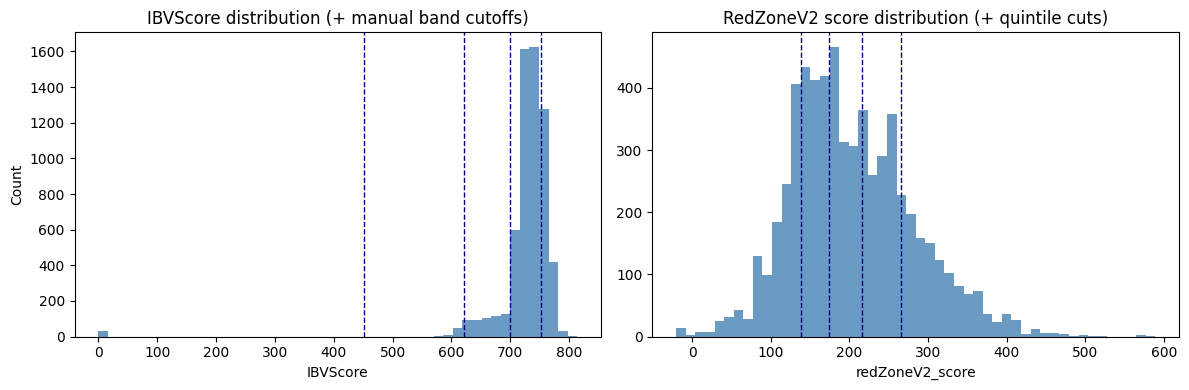

In [24]:
import matplotlib.pyplot as plt

df = df_perf_merged_dedup_kept.dropna(subset=["IBVScore","redZoneV2_score"])

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# IBVScore
axes[0].hist(df["IBVScore"], bins=50, color="steelblue", alpha=0.8)

# manual band cutoffs
for c in [452, 621, 700, 753]:
    axes[0].axvline(c, color="navy", linestyle="--", linewidth=1)

axes[0].set_title("IBVScore distribution (+ manual band cutoffs)")
axes[0].set_xlabel("IBVScore")
axes[0].set_ylabel("Count")

# RedZone
axes[1].hist(df["redZoneV2_score"], bins=50, color="steelblue", alpha=0.8)
for c in df["redZoneV2_score"].quantile([.2,.4,.6,.8]):
    axes[1].axvline(c, color="navy", linestyle="--", linewidth=1)
axes[1].set_title("RedZoneV2 score distribution (+ quintile cuts)")
axes[1].set_xlabel("redZoneV2_score")

plt.tight_layout()
plt.show()

### Swap analysis (scenario-based)
We’ll start with a **5-band (quintile) RedZone** design and use the **Q3 cutoff** (boundary between band 3 and band 4, i.e. 60th percentile) as the “good” threshold.

- **Swap-in**: low IBV band (1–2) but high RedZone (band 4–5)
- **Swap-out**: high IBV band (4–5) but low RedZone (band 1–3)



In [25]:
import numpy as np
import pandas as pd

# Base for swap analysis: needs both scores
swap_base = df_perf_merged_dedup_kept.dropna(subset=["redZoneV2_score"]).copy()

# Ensure numeric
swap_base["redZoneV2_score"] = pd.to_numeric(swap_base["redZoneV2_score"], errors="coerce")
swap_base["IBVScore"] = pd.to_numeric(swap_base["IBVScore"], errors="coerce")

# 1) RedZone 5-bandC quintile bands + cutoffs
rz_quantiles = swap_base["redZoneV2_score"].dropna().quantile([0.2, 0.4, 0.6, 0.8])
rz_cut_q3 = float(rz_quantiles.loc[0.6])
print("RedZone quintile cutoffs (20/40/60/80%):")
print(rz_quantiles)
print("\nQ3 cutoff (band3->band4 boundary):", rz_cut_q3)

swap_base["RedZoneBand5"] = pd.qcut(
    swap_base["redZoneV2_score"],
    q=5,
    labels=[1, 2, 3, 4, 5],
    duplicates="drop",
).astype("Int64")

# 2) IBV bands
# Prefer the existing IBVBand column when present; otherwise compute from IBVScore.
if "IBVBand" in swap_base.columns:
    swap_base["IBVBand_existing"] = pd.to_numeric(swap_base["IBVBand"], errors="coerce").astype("Int64")
else:
    swap_base["IBVBand_existing"] = pd.NA

# Manual banding (matches rerun_analysis_V0 cutoffs)
def ibv_band_fn(x):
    if pd.isna(x):
        return pd.NA
    if x < 452:
        return 1
    if x < 621:
        return 2
    if x < 700:
        return 3
    if x < 753:
        return 4
    return 5

swap_base["IBVBand_manual"] = swap_base["IBVScore"].apply(ibv_band_fn).astype("Int64")

# Choose which IBV band definition to use for swap logic
# (manual is safest/explicit; existing sometimes has a 0 category)
ibv_band_col = "IBVBand_manual"

# 3) Define swap-in / swap-out (scenario: cutoff at RedZone band 3)
rz_high = swap_base["RedZoneBand5"].isin([4, 5])
rz_low = swap_base["RedZoneBand5"].isin([1, 2, 3])

ibv_low = swap_base[ibv_band_col].isin([1, 2])
ibv_high = swap_base[ibv_band_col].isin([4, 5])

swap_in_mask = ibv_low & rz_high
swap_out_mask = ibv_high & rz_low

print("\nCounts:")
print("Total rows (swap_base):", len(swap_base))
print("Swap-in candidates:", int(swap_in_mask.sum()))
print("Swap-out candidates:", int(swap_out_mask.sum()))

# 4) Summaries (uses what exists; Accepted/Originated are present in V1)
def summarize_segment(df: pd.DataFrame, name: str) -> dict:
    out = {"segment": name, "n": len(df)}
    if len(df) == 0:
        return out

    for col in ["Accepted", "Originated"]:
        if col in df.columns:
            out[f"{col}_rate"] = pd.to_numeric(df[col], errors="coerce").mean()

    out["IBVScore_mean"] = pd.to_numeric(df["IBVScore"], errors="coerce").mean()
    out["RedZone_mean"] = pd.to_numeric(df["redZoneV2_score"], errors="coerce").mean()
    out["RedZone_median"] = pd.to_numeric(df["redZoneV2_score"], errors="coerce").median()
    return out

segments = pd.DataFrame([
    summarize_segment(swap_base, "All"),
    summarize_segment(swap_base.loc[ibv_low], "IBV low (bands 1-2)"),
    summarize_segment(swap_base.loc[ibv_high], "IBV high (bands 4-5)"),
    summarize_segment(swap_base.loc[rz_low], "RedZone low (bands 1-3)"),
    summarize_segment(swap_base.loc[rz_high], "RedZone high (bands 4-5)"),
    summarize_segment(swap_base.loc[swap_in_mask], "Swap-in"),
    summarize_segment(swap_base.loc[swap_out_mask], "Swap-out"),
])

segments


RedZone quintile cutoffs (20/40/60/80%):
0.2    138.0
0.4    173.0
0.6    214.0
0.8    265.0
Name: redZoneV2_score, dtype: float64

Q3 cutoff (band3->band4 boundary): 214.0

Counts:
Total rows (swap_base): 6420
Swap-in candidates: 7
Swap-out candidates: 3201


,segment,n,Accepted_rate,Originated_rate,IBVScore_mean,RedZone_mean,RedZone_median
0,All,6420,0.720717,0.445639,727.728359,202.331679,193.0
1,IBV low (bands 1-2),101,0.009901,0.000000,435.118812,122.636402,124.0
2,IBV high (bands 4-5),5583,0.823751,0.508329,738.964893,209.058907,199.0
3,RedZone low (bands 1-3),3874,0.675529,0.397522,720.303972,151.577168,155.0
4,RedZone high (bands 4-5),2546,0.789474,0.518853,738.759133,279.559869,265.5
5,Swap-in,7,0.142857,0.000000,263.714286,253.969962,248.0
6,Swap-out,3201,0.813496,0.477976,735.862543,155.802862,160.0


In [29]:
# Scenario variant: use RedZone cutoff at band2 (given cutoff score = 173)
rz_cut_b2 = 173.0

# (optional) compare to the empirical 40th percentile cutoff
try:
    rz_cut_p40 = float(swap_base["redZoneV2_score"].dropna().quantile(0.4))
    print("RedZone 40th percentile cutoff:", rz_cut_p40)
except Exception as e:
    print("Could not compute 40th percentile cutoff:", e)

print("Using band2 cutoff score:", rz_cut_b2)

rz_high_b2 = swap_base["redZoneV2_score"] > rz_cut_b2   # bands 3-5
rz_low_b2 = swap_base["redZoneV2_score"] <= rz_cut_b2   # bands 1-2

swap_in_mask_b2 = ibv_low & rz_high_b2
swap_out_mask_b2 = ibv_high & rz_low_b2

print("\nCounts (band2 cutoff):")
print("Total rows (swap_base):", len(swap_base))
print("Swap-in candidates:", int(swap_in_mask_b2.sum()))
print("Swap-out candidates:", int(swap_out_mask_b2.sum()))

segments_b2 = pd.DataFrame([
    summarize_segment(swap_base, "All"),
    summarize_segment(swap_base.loc[ibv_low], "IBV low (bands 1-2)"),
    summarize_segment(swap_base.loc[ibv_high], "IBV high (bands 4-5)"),
    summarize_segment(swap_base.loc[rz_low_b2], "RedZone low (<= band2 cutoff)"),
    summarize_segment(swap_base.loc[rz_high_b2], "RedZone high (> band2 cutoff)"),
    summarize_segment(swap_base.loc[swap_in_mask_b2], "Swap-in (band2 cutoff)"),
    summarize_segment(swap_base.loc[swap_out_mask_b2], "Swap-out (band2 cutoff)"),
])

segments_b2


RedZone 40th percentile cutoff: 173.0
Using band2 cutoff score: 173.0

Counts (band2 cutoff):
Total rows (swap_base): 6420
Swap-in candidates: 18
Swap-out candidates: 2040


,segment,n,Accepted_rate,Originated_rate,IBVScore_mean,RedZone_mean,RedZone_median
0,All,6420,0.720717,0.445639,727.728359,202.331679,193.0
1,IBV low (bands 1-2),101,0.009901,0.000000,435.118812,122.636402,124.0
2,IBV high (bands 4-5),5583,0.823751,0.508329,738.964893,209.058907,199.0
3,RedZone low (<= band2 cutoff),2585,0.636750,0.367118,715.497760,130.676635,138.0
4,RedZone high (> band2 cutoff),3835,0.777314,0.498566,735.763179,250.631102,239.0
5,Swap-in (band2 cutoff),18,0.055556,0.000000,272.611111,218.807843,207.0
6,Swap-out (band2 cutoff),2040,0.802451,0.462255,734.566667,134.406135,141.0


In [32]:
# Optional exports: swap-in / swap-out populations + scenario summary
out_dir = "/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/misc_out_data"
os.makedirs(out_dir, exist_ok=True)

swap_in_df_b2 = swap_base.loc[swap_in_mask_b2].copy()
swap_out_df_b2 = swap_base.loc[swap_out_mask_b2].copy()

# Keep a compact set of columns if present
keep_cols = [c for c in [
    "IBVStatusID", "CustomerID", "CustEmail", "ApplicationDate",
    "IBVScore", "IBVBand", "IBVBand_manual", "RedZoneBand5", "redZoneV2_score",
    "Accepted", "Originated",
] if c in swap_base.columns]

swap_in_df_b2[keep_cols].to_csv(os.path.join(out_dir, "swap_in_candidates_Q2cut.csv"), index=False)
swap_out_df_b2[keep_cols].to_csv(os.path.join(out_dir, "swap_out_candidates_Q2cut.csv"), index=False)
segments_b2.to_csv(os.path.join(out_dir, "swap_scenario_summary_Q2cut.csv"), index=False)

print("Wrote:")
print(os.path.join(out_dir, "swap_in_candidates_Q2cut.csv"))
print(os.path.join(out_dir, "swap_out_candidates_Q2cut.csv"))
print(os.path.join(out_dir, "swap_scenario_summary_Q2cut.csv"))


Wrote:
/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/misc_out_data/swap_in_candidates_Q2cut.csv
/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/misc_out_data/swap_out_candidates_Q2cut.csv
/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/misc_out_data/swap_scenario_summary_Q2cut.csv
